In [172]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler,Normalizer
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np

In [173]:
movie_df = pd.read_csv('data/data_regression.csv')

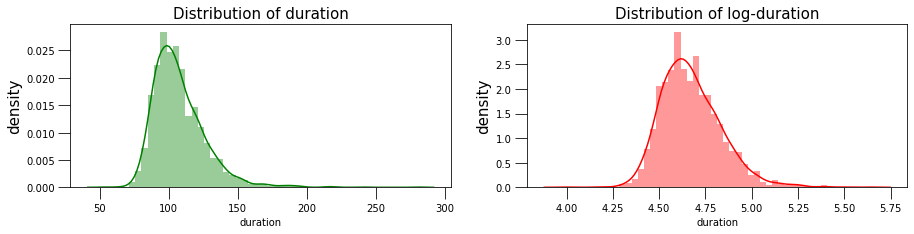

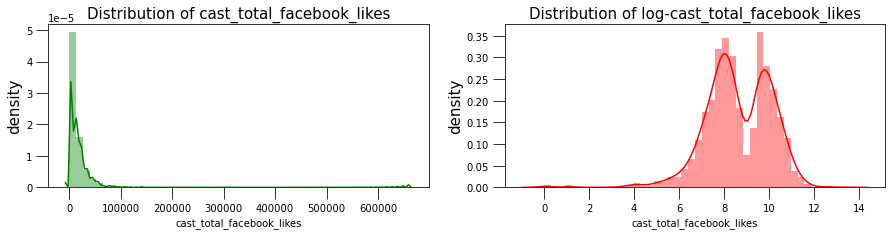

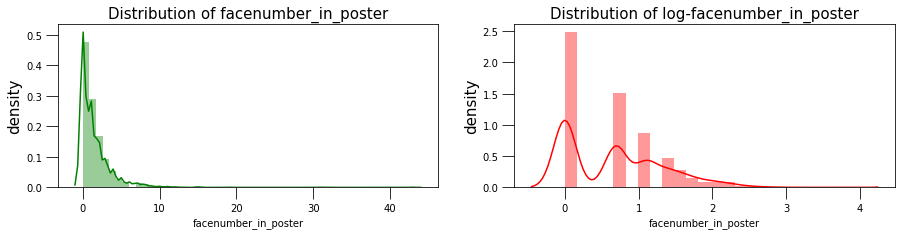

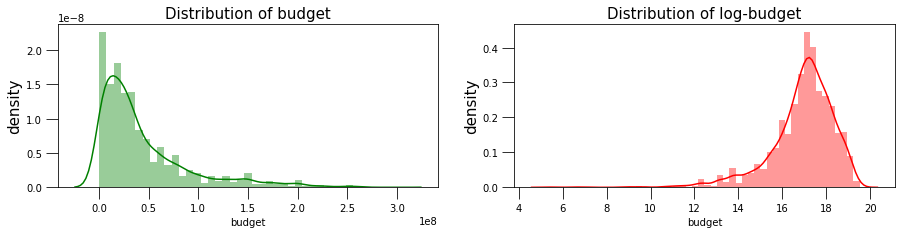

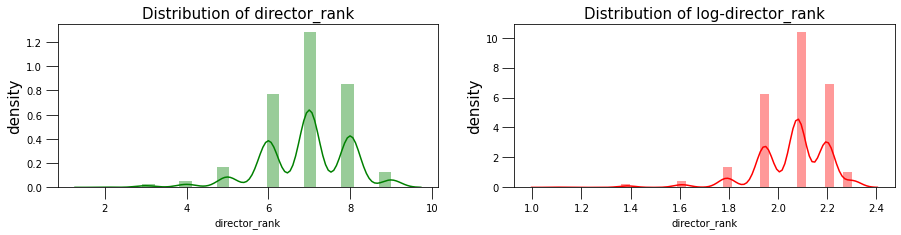

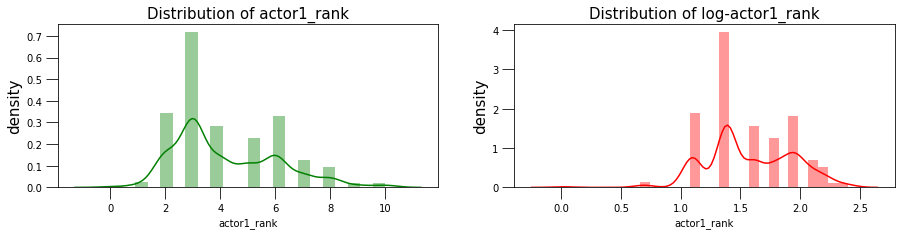

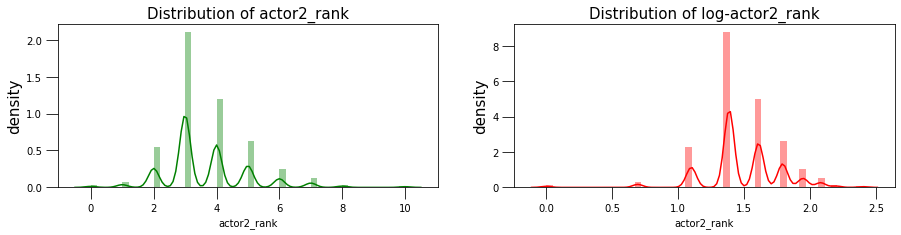

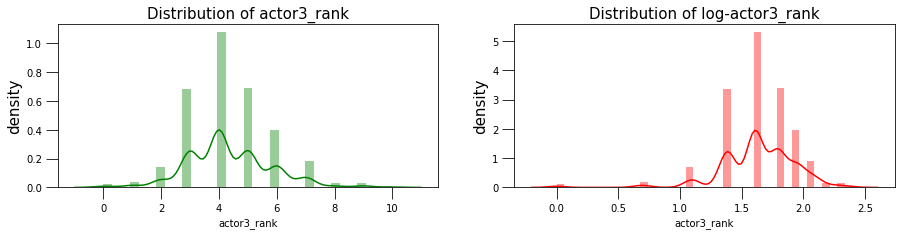

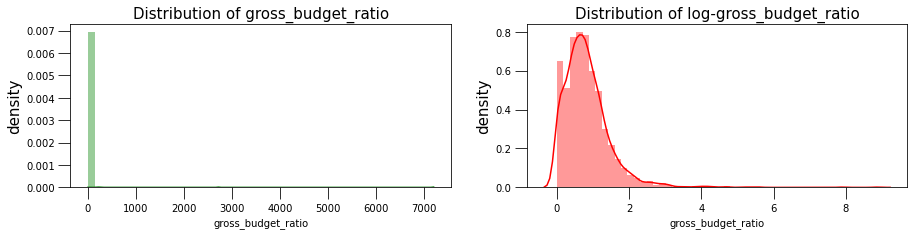

In [174]:
for col in ['duration', 'cast_total_facebook_likes', 'facenumber_in_poster',
       'budget', 'director_rank', 'actor1_rank', 'actor2_rank', 'actor3_rank','gross_budget_ratio']:
    
    _, (ax1, ax2) = plt.subplots(figsize=(15,3), nrows=1, ncols=2)
    sns.distplot(movie_df[col].fillna(0),color='g', ax=ax1)
    sns.distplot(np.log(movie_df[col].fillna(0) + 1), color="r", ax=ax2)
    for ax in (ax1, ax2):
        ax.tick_params(size=12)
        ax.set_ylabel("density", size=15)
    ax1.set_title(f"Distribution of {col}", size=15)
    ax2.set_title(f"Distribution of log-{col}", size=15)

From these plots we see that for duration, cast facebook likes, budget and gross_budget ratio it is better to use the log version and use the normalization to scalar.

In [175]:
# use the log

#substitude 0 with 1
movie_df.cast_total_facebook_likes = [ 1 if x==0 else x for x in movie_df.cast_total_facebook_likes ]

for col in ['duration', 'cast_total_facebook_likes', 'budget','gross_budget_ratio']:
    name = 'log_' + col
    movie_df[name] = np.log(movie_df[col])

## not log: normal features

In [176]:
# movie_df = movie_df[movie_df['gross'].isna() == False]
movie_df = movie_df[(movie_df['gross_budget_ratio'] <= 10) & (movie_df['budget'] >= 500000)]

# cut outlayers
movie_df = movie_df[(np.abs(stats.zscore(movie_df['log_budget'], nan_policy='omit')) < 3)]
movie_df = movie_df[(np.abs(stats.zscore(movie_df['log_gross_budget_ratio'], nan_policy='omit')) < 3)]

X = movie_df[['duration', 'cast_total_facebook_likes', 'facenumber_in_poster',
       'budget', 'Biography', 'Comedy', 'Crime', 'Drama', 'Romance',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy', 'Family_Animation',
       'Action_Adventure', 'History_War', 'Others', 'director_rank',
       'actor1_rank', 'actor2_rank', 'actor3_rank']]

y = movie_df['gross_budget_ratio']


# X = pd.get_dummies(X, columns=['content_rating'])

display(X.head())


,duration,cast_total_facebook_likes,facenumber_in_poster,budget,Biography,Comedy,Crime,Drama,Romance,Mystery_Thriller_Horror,Sci-Fi_Fantasy,Family_Animation,Action_Adventure,History_War,Others,director_rank,actor1_rank,actor2_rank,actor3_rank
0,123.0,22209,1.0,48000000.0,0,1,0,0,1,0,1,0,0,0,0,8,6,4,4
488,104.0,1854,1.0,22000000.0,0,0,0,1,1,0,0,0,0,0,1,2,2,2,3
611,123.0,7072,0.0,12000000.0,1,0,0,1,1,0,0,0,0,0,0,7,4,4,4
612,122.0,41636,1.0,35000000.0,0,0,0,0,0,1,0,0,0,0,0,8,9,5,3
627,123.0,11930,0.0,125000000.0,0,0,0,0,0,1,0,0,1,0,0,7,7,3,6


In [177]:
# normalization/scaling: some columns prefer the normalization 
MMScaler = MinMaxScaler()
scaled_X = pd.DataFrame(MMScaler.fit_transform(X[['duration', 'cast_total_facebook_likes', 'facenumber_in_poster',
       'budget', 'Biography', 'Comedy', 'Crime', 'Drama', 'Romance',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy', 'Family_Animation',
       'Action_Adventure', 'History_War', 'Others', 'director_rank',
       'actor1_rank', 'actor2_rank', 'actor3_rank']]))

normalizer = Normalizer().fit(X[['duration','budget']])

a = normalizer.transform(X[['duration','budget']])

scaled_X['log_duration'] = a[:,0]
scaled_X['log_budget'] = a[:,1]

display(scaled_X)

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.3, random_state=10)

print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,log_duration,log_budget
0,0.308370,0.033816,0.023256,0.158035,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.857143,0.6,0.4,0.4,2.562500e-06,1.0
1,0.224670,0.002822,0.023256,0.071166,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.000000,0.2,0.2,0.3,4.727273e-06,1.0
2,0.308370,0.010767,0.000000,0.037755,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.714286,0.4,0.4,0.4,1.025000e-05,1.0
3,0.303965,0.063398,0.023256,0.114601,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.857143,0.9,0.5,0.3,3.485714e-06,1.0
4,0.308370,0.018164,0.000000,0.415302,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.714286,0.7,0.3,0.6,9.840000e-07,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2085,0.299559,0.010074,0.000000,0.014367,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.714286,0.4,0.3,0.4,2.420000e-05,1.0
2086,0.171806,0.027194,0.000000,0.114601,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.714286,0.5,0.3,0.4,2.628571e-06,1.0
2087,0.207048,0.028604,0.209302,0.064484,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.714286,0.5,0.5,0.5,5.000000e-06,1.0
2088,0.171806,0.004335,0.093023,0.014367,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.428571,0.2,0.4,0.4,1.840000e-05,1.0


Dimensionality of X_train: (1463, 21)
Dimensionality of X_test : (627, 21)
Dimensionality of y_train: (1463,)
Dimensionality of y_test : (627,)


In [178]:
X.columns

Index(['duration', 'cast_total_facebook_likes', 'facenumber_in_poster',
       'budget', 'Biography', 'Comedy', 'Crime', 'Drama', 'Romance',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy', 'Family_Animation',
       'Action_Adventure', 'History_War', 'Others', 'director_rank',
       'actor1_rank', 'actor2_rank', 'actor3_rank'],
      dtype='object')

In [179]:
params = {
    'n_estimators': [60, 80, 100, 150, 200],
    'max_depth': [2, 3, 6, 8],
    'learning_rate': [0.02, 0.05, 0.07, 0.1, 0.5],
    'subsample': [0.6, 0.8, 1]
}

clf = GridSearchCV(XGBRegressor(silent=False), params, scoring ='neg_mean_squared_error')

In [180]:
clf.fit(X_train, y_train)

clf.best_params_

{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 150, 'subsample': 1}

In [181]:
print(clf.best_score_)

np.exp(np.abs(clf.best_score_))

-2.1403069988555505


8.502047347080767

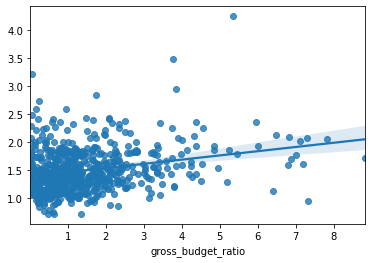

In [182]:
sns.regplot(y_test, clf.predict(X_test))

It is really bad, so we try with log

### LOG

In [183]:
# movie_df = movie_df[movie_df['gross'].isna() == False]
movie_df = movie_df[(movie_df['gross_budget_ratio'] <= 10) & (movie_df['budget'] >= 500000)]

# cut outlyers
movie_df = movie_df[(np.abs(stats.zscore(movie_df['log_budget'], nan_policy='omit')) < 3)]
movie_df = movie_df[(np.abs(stats.zscore(movie_df['log_gross_budget_ratio'], nan_policy='omit')) < 3)]

X = movie_df[['log_duration', 'log_cast_total_facebook_likes', 'facenumber_in_poster',
       'log_budget', 'Biography', 'Comedy', 'Crime', 'Drama', 'Romance',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy', 'Family_Animation',
       'Action_Adventure', 'History_War', 'Others', 'director_rank',
       'actor1_rank', 'actor2_rank', 'actor3_rank']]

y = movie_df['log_gross_budget_ratio']


# X = pd.get_dummies(X, columns=['content_rating'])

display(X.head())


,log_duration,log_cast_total_facebook_likes,facenumber_in_poster,log_budget,Biography,Comedy,Crime,Drama,Romance,Mystery_Thriller_Horror,Sci-Fi_Fantasy,Family_Animation,Action_Adventure,History_War,Others,director_rank,actor1_rank,actor2_rank,actor3_rank
0,4.812184,10.008253,1.0,17.686712,0,1,0,0,1,0,1,0,0,0,0,8,6,4,4
488,4.644391,7.525101,1.0,16.906553,0,0,0,1,1,0,0,0,0,0,1,2,2,2,3
611,4.812184,8.863899,0.0,16.300417,1,0,0,1,1,0,0,0,0,0,0,7,4,4,4
612,4.804021,10.636720,1.0,17.370859,0,0,0,0,0,1,0,0,0,0,0,8,9,5,3
627,4.812184,9.386812,0.0,18.643824,0,0,0,0,0,1,0,0,1,0,0,7,7,3,6


In [184]:
# normalization: some columns prefer the normalization 
MMScaler = MinMaxScaler()
scaled_X = pd.DataFrame(MMScaler.fit_transform(X[['log_cast_total_facebook_likes', 'facenumber_in_poster',
           'Biography', 'Comedy', 'Crime', 'Drama', 'Romance',
           'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy', 'Family_Animation',
           'Action_Adventure', 'History_War', 'Others', 'director_rank',
           'actor1_rank', 'actor2_rank', 'actor3_rank']]))

normalizer = Normalizer().fit(X[['log_duration','log_budget']])

a = normalizer.transform(X[['log_duration','log_budget']])

scaled_X['log_duration'] = a[:,0]
scaled_X['log_budget'] = a[:,1]

display(scaled_X)

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.3, random_state=10)

print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,log_duration,log_budget
0,0.747162,0.023256,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.857143,0.6,0.4,0.4,0.262535,0.964922
1,0.561783,0.023256,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.2,0.2,0.3,0.264896,0.964277
2,0.661730,0.000000,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.714286,0.4,0.4,0.4,0.283138,0.959079
3,0.794080,0.023256,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.857143,0.9,0.5,0.3,0.266551,0.963821
4,0.700768,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.714286,0.7,0.3,0.6,0.249921,0.968266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2028,0.656766,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.714286,0.4,0.3,0.4,0.296893,0.954911
2029,0.730892,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.714286,0.5,0.3,0.4,0.251914,0.967750
2030,0.734666,0.209302,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.714286,0.5,0.5,0.5,0.264200,0.964468
2031,0.593830,0.093023,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.428571,0.2,0.4,0.4,0.281310,0.959617


Dimensionality of X_train: (1423, 19)
Dimensionality of X_test : (610, 19)
Dimensionality of y_train: (1423,)
Dimensionality of y_test : (610,)


In [185]:
X.columns

Index(['log_duration', 'log_cast_total_facebook_likes', 'facenumber_in_poster',
       'log_budget', 'Biography', 'Comedy', 'Crime', 'Drama', 'Romance',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy', 'Family_Animation',
       'Action_Adventure', 'History_War', 'Others', 'director_rank',
       'actor1_rank', 'actor2_rank', 'actor3_rank'],
      dtype='object')

In [186]:
params = {
    'n_estimators': [40, 60, 80, 100, 200],
    'max_depth': [3, 6, 8],
    'learning_rate': [0.02, 0.05, 0.07, 0.1],
    'subsample': [0.6, 0.8, 1]
}

clf = GridSearchCV(XGBRegressor(silent=False), params, scoring ='neg_mean_squared_error')

In [187]:
clf.fit(X_train, y_train)

clf.best_params_

{'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 60, 'subsample': 1}

In [188]:
print(clf.best_score_)

np.exp(np.abs(clf.best_score_))

-1.0899573087216066


2.974147099710951

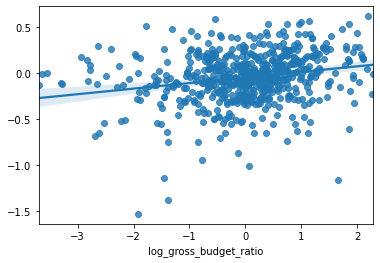

In [189]:
sns.regplot(y_test, clf.predict(X_test))

In [190]:
best_clf = XGBRegressor(**clf.best_params_)
best_clf.fit(X_train, y_train)
pd.DataFrame({'Variable':X.columns,
              'Importance':best_clf.feature_importances_}).sort_values('Importance', ascending=False)

,Variable,Importance
6,Crime,0.096245
13,History_War,0.090778
0,log_duration,0.079182
5,Comedy,0.078638
17,actor2_rank,0.073238
3,log_budget,0.073227
1,log_cast_total_facebook_likes,0.068141
10,Sci-Fi_Fantasy,0.061895
14,Others,0.060730
7,Drama,0.054328


### Drop Actor 3 Rank

In [191]:

X = movie_df[['log_duration', 'log_cast_total_facebook_likes', 'facenumber_in_poster',
       'log_budget', 'Biography', 'Comedy', 'Crime', 'Drama', 'Romance',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy', 'Family_Animation',
       'Action_Adventure', 'History_War', 'Others', 'director_rank',
       'actor1_rank', 'actor2_rank']]

y = movie_df['log_gross_budget_ratio']


# X = pd.get_dummies(X, columns=['content_rating'])

display(X.head())


,log_duration,log_cast_total_facebook_likes,facenumber_in_poster,log_budget,Biography,Comedy,Crime,Drama,Romance,Mystery_Thriller_Horror,Sci-Fi_Fantasy,Family_Animation,Action_Adventure,History_War,Others,director_rank,actor1_rank,actor2_rank
0,4.812184,10.008253,1.0,17.686712,0,1,0,0,1,0,1,0,0,0,0,8,6,4
488,4.644391,7.525101,1.0,16.906553,0,0,0,1,1,0,0,0,0,0,1,2,2,2
611,4.812184,8.863899,0.0,16.300417,1,0,0,1,1,0,0,0,0,0,0,7,4,4
612,4.804021,10.636720,1.0,17.370859,0,0,0,0,0,1,0,0,0,0,0,8,9,5
627,4.812184,9.386812,0.0,18.643824,0,0,0,0,0,1,0,0,1,0,0,7,7,3


In [192]:
# normalization: some columns prefer the normalization 

scaled_X = pd.DataFrame(MMScaler.fit_transform(X[['log_cast_total_facebook_likes', 'facenumber_in_poster',
           'Biography', 'Comedy', 'Crime', 'Drama', 'Romance',
           'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy', 'Family_Animation',
           'Action_Adventure', 'History_War', 'Others', 'director_rank',
           'actor1_rank', 'actor2_rank']]))

a = normalizer.transform(X[['log_duration','log_budget']])

scaled_X['log_duration'] = a[:,0]
scaled_X['log_budget'] = a[:,1]

display(scaled_X)

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.3, random_state=10)

print(f"Dimensionality of X_train: {X_train.shape}")
print(f"Dimensionality of X_test : {X_test.shape}")
print(f"Dimensionality of y_train: {y_train.shape}")
print(f"Dimensionality of y_test : {y_test.shape}")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,log_duration,log_budget
0,0.747162,0.023256,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.857143,0.6,0.4,0.262535,0.964922
1,0.561783,0.023256,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.2,0.2,0.264896,0.964277
2,0.661730,0.000000,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.714286,0.4,0.4,0.283138,0.959079
3,0.794080,0.023256,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.857143,0.9,0.5,0.266551,0.963821
4,0.700768,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.714286,0.7,0.3,0.249921,0.968266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2028,0.656766,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.714286,0.4,0.3,0.296893,0.954911
2029,0.730892,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.714286,0.5,0.3,0.251914,0.967750
2030,0.734666,0.209302,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.714286,0.5,0.5,0.264200,0.964468
2031,0.593830,0.093023,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.428571,0.2,0.4,0.281310,0.959617


Dimensionality of X_train: (1423, 18)
Dimensionality of X_test : (610, 18)
Dimensionality of y_train: (1423,)
Dimensionality of y_test : (610,)


In [193]:
X.columns

Index(['log_duration', 'log_cast_total_facebook_likes', 'facenumber_in_poster',
       'log_budget', 'Biography', 'Comedy', 'Crime', 'Drama', 'Romance',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy', 'Family_Animation',
       'Action_Adventure', 'History_War', 'Others', 'director_rank',
       'actor1_rank', 'actor2_rank'],
      dtype='object')

In [194]:
params = {
     'n_estimators': [100, 150, 200, 300, 500],
    'max_depth': [2, 3, 6],
    'learning_rate': [0.01, 0.02, 0.05, 0.5],
    'subsample': [0.8, 1]
}

clf = GridSearchCV(XGBRegressor(silent=False), params, scoring ='neg_mean_squared_error')

In [195]:
clf.fit(X_train, y_train)

clf.best_params_

{'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.8}

In [196]:
print(clf.best_score_)

np.exp(np.abs(clf.best_score_))

-1.0883926246135007


2.9694971378182866

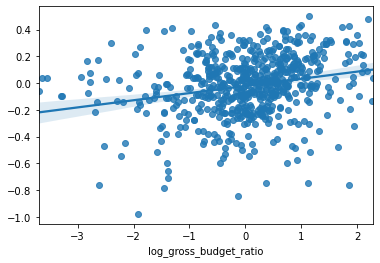

In [197]:
sns.regplot(y_test, clf.predict(X_test))

In [198]:
best_clf = XGBRegressor(**clf.best_params_)
best_clf.fit(X_train, y_train)
pd.DataFrame({'Variable':X.columns,
              'Importance':best_clf.feature_importances_}).sort_values('Importance', ascending=False)

,Variable,Importance
6,Crime,0.075575
5,Comedy,0.074869
13,History_War,0.073684
0,log_duration,0.072663
3,log_budget,0.071469
10,Sci-Fi_Fantasy,0.071442
16,actor1_rank,0.067667
11,Family_Animation,0.063707
7,Drama,0.057307
9,Mystery_Thriller_Horror,0.055271
